In [15]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [57]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()
lrets.head(3)

,SPY,TLT,MSFT
Date,,,
2007-01-04,0.002120,0.006045,-0.001676
2007-01-05,-0.008008,-0.004362,-0.005719
2007-01-08,0.004614,0.001791,0.009736


In [17]:
data.head(3)

,SPY,TLT,MSFT
Date,,,
2007-01-03,110.520622,59.896599,22.478832
2007-01-04,110.755142,60.259796,22.441185
2007-01-05,109.871742,59.997501,22.313211


In [50]:
def tsplot(y, lags=None, figsize=(15, 12), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return 

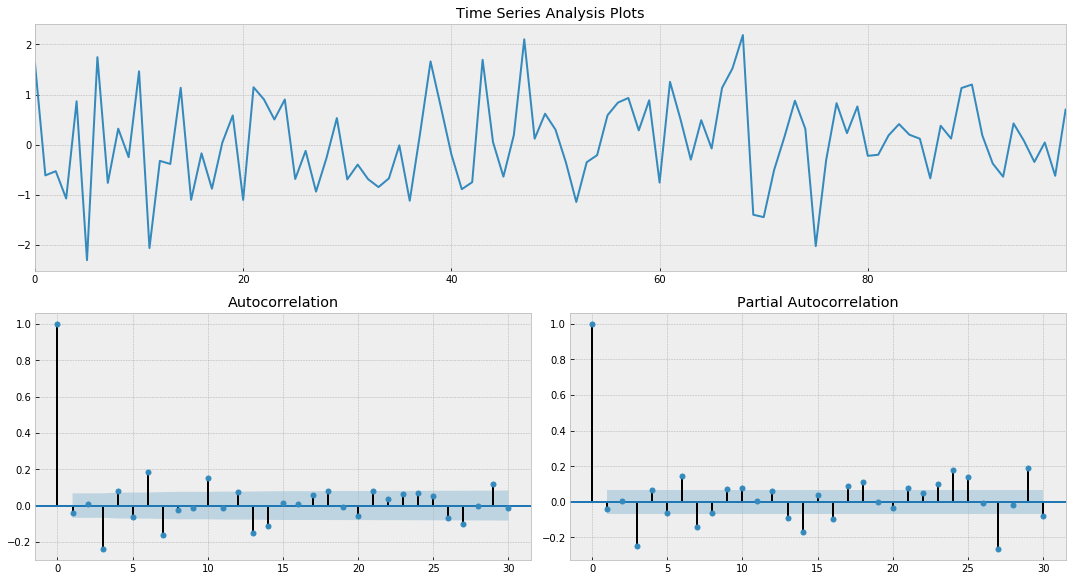

In [20]:
np.random.seed(1)

# plot of discrete white noise
rand_series = np.random.normal(size=100)
tsplot(rand_series, lags=30)

In [22]:
print("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(rand_series.mean(), rand_series.var(), rand_series.std()))

Random Series
 -------------
mean: 0.061
variance: 0.784
standard deviation: 0.885


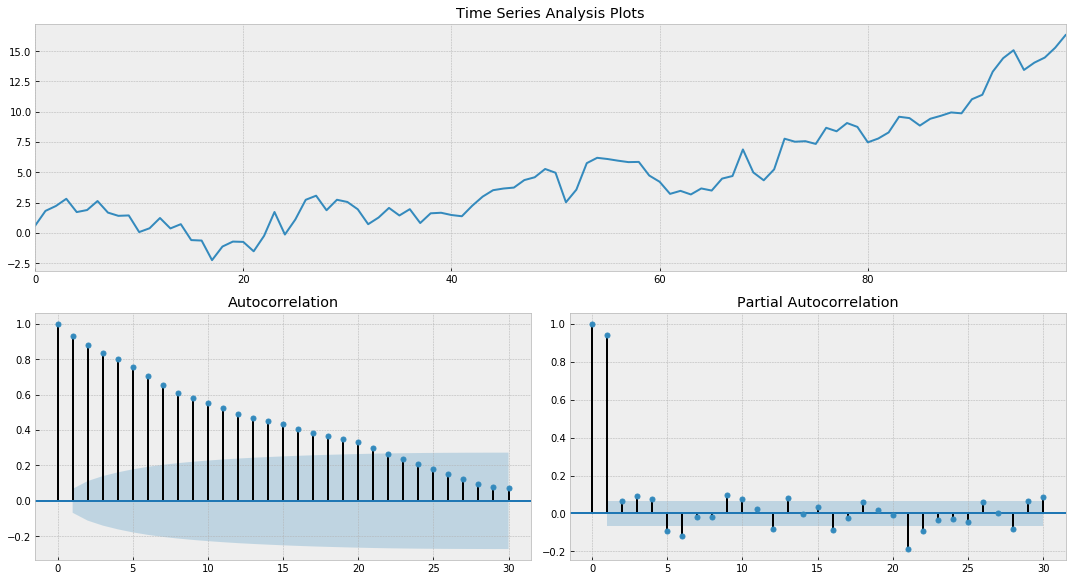

In [23]:
x = w = np.random.normal(size=100)
for t in range(100):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

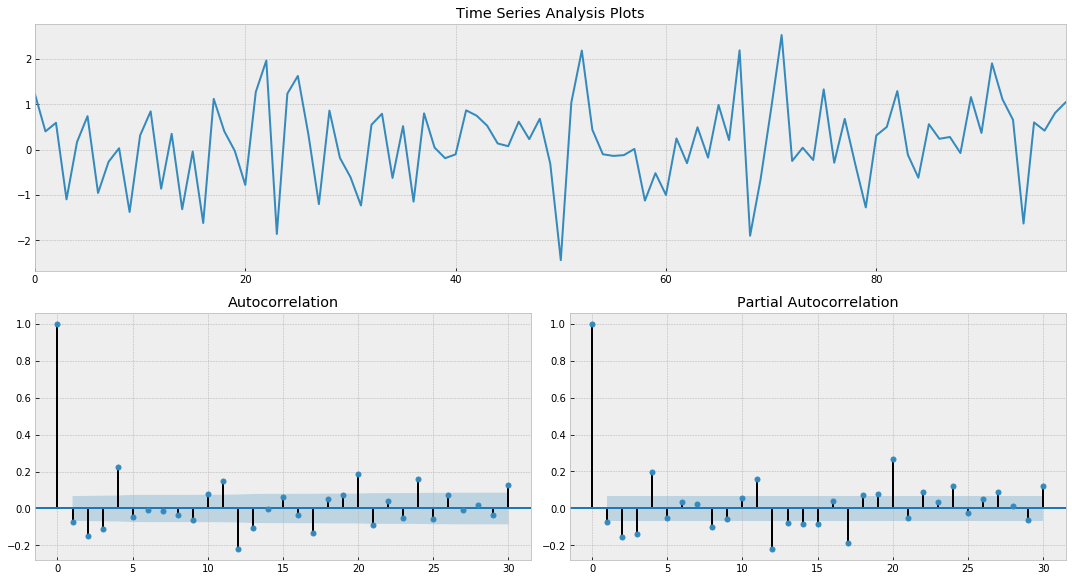

In [25]:
_ = tsplot(np.diff(x), lags=30)

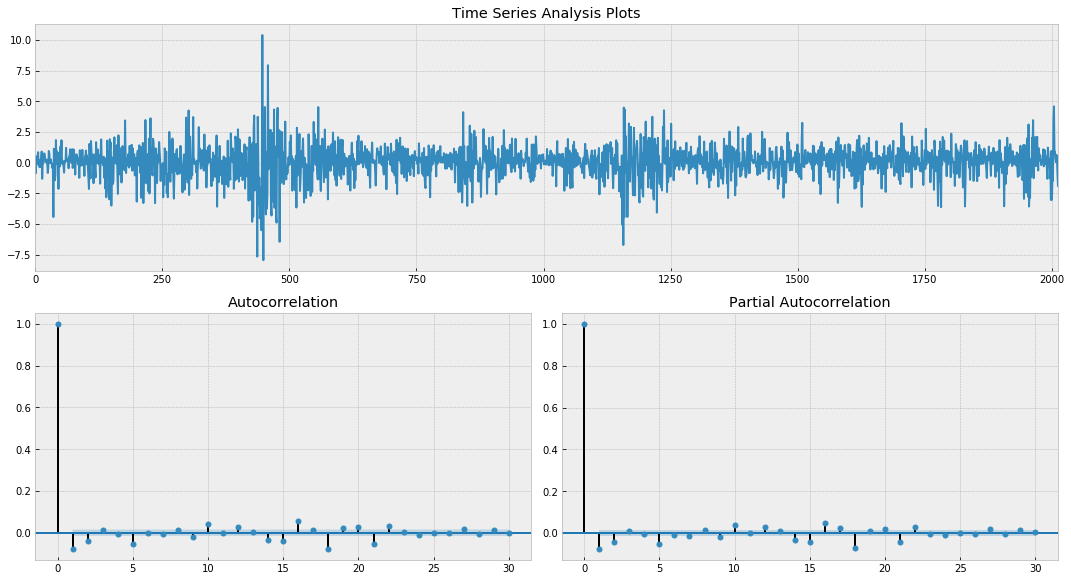

In [26]:
_ = tsplot(np.diff(data.SPY), lags=30)

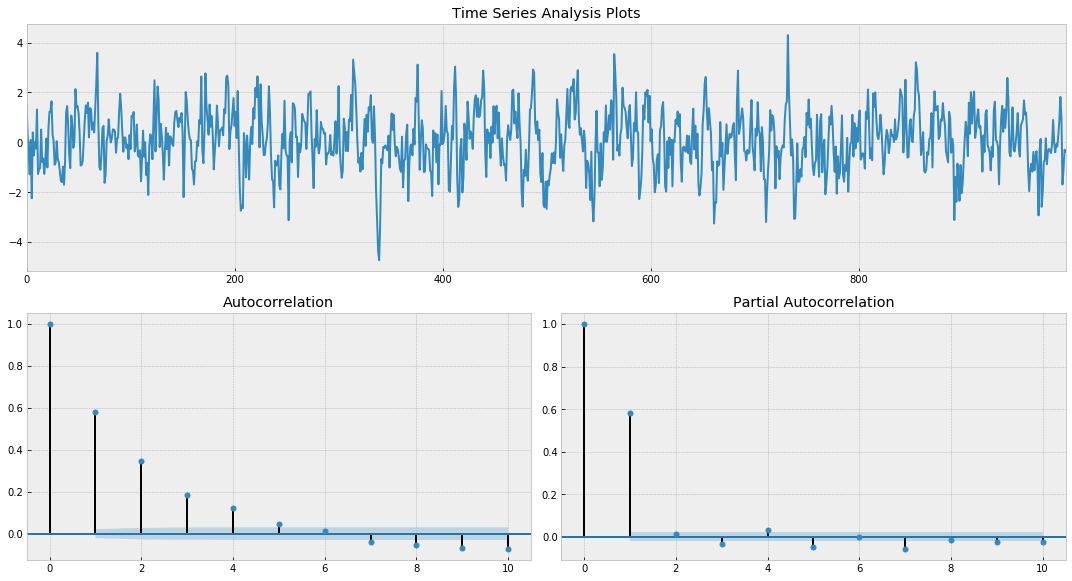

In [28]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=10)

In [29]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

CPU times: user 33 s, sys: 41.9 s, total: 1min 14s
Wall time: 19.9 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


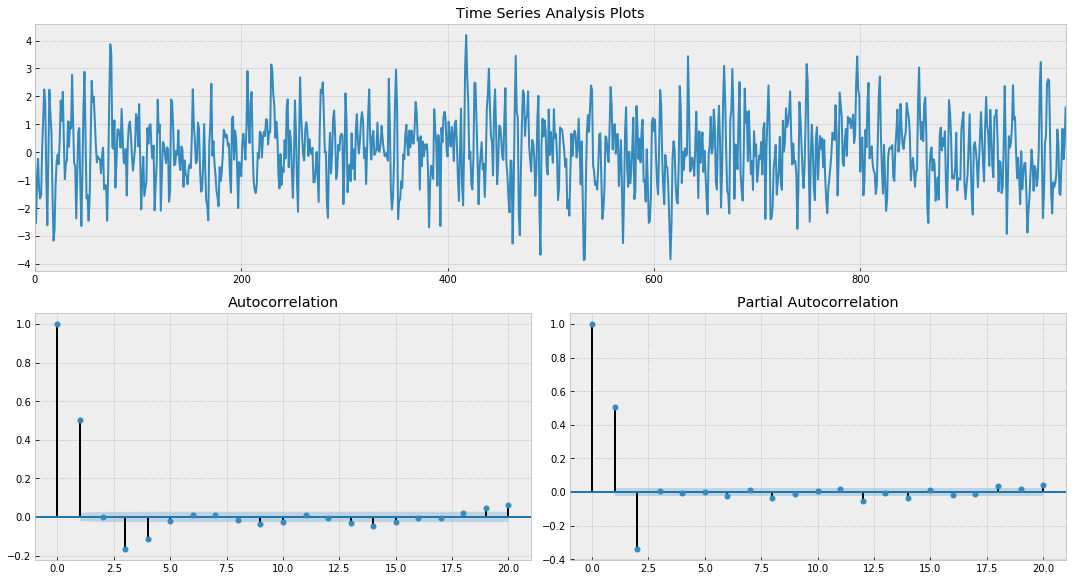

In [30]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=20)

In [31]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'
  .format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


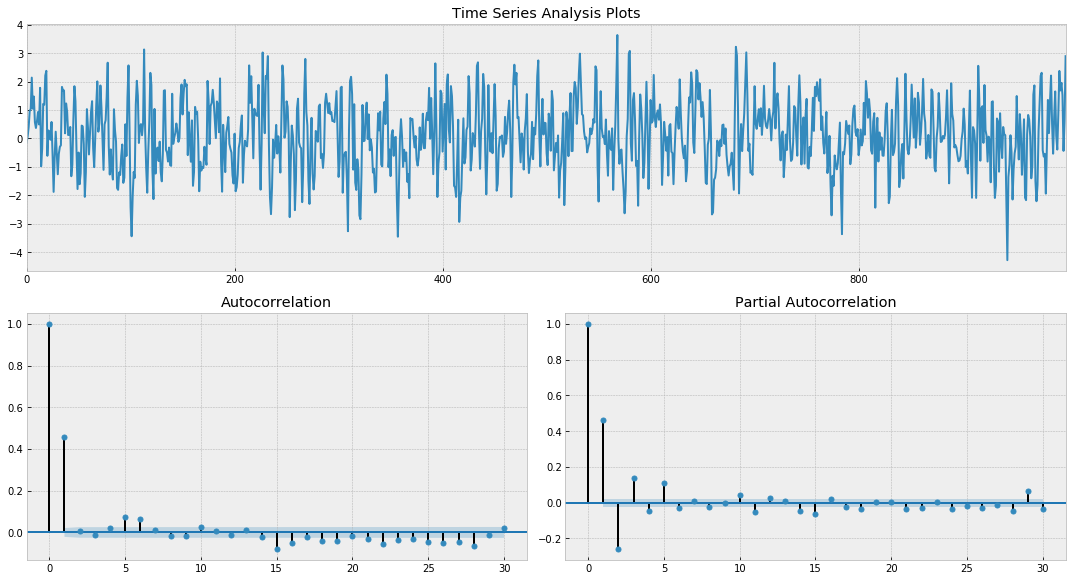

In [35]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [36]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
model = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1438.725
Method:                           mle   S.D. of innovations              1.020
Date:                Mon, 04 Mar 2019   AIC                           2881.451
Time:                        08:19:46   BIC                           2891.266
Sample:                             0   HQIC                          2885.182
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6214      0.024     26.074      0.000       0.575       0.668
                                    Roots                                    
                  Real          Imaginary           M

ARCH(p) model is simply an AR(p) model applied to the variance of a time series.
ARCH(1)
Var(x(t)) = σ²(t) = ⍺*σ²(t-1) + ⍺1

The actual time series is given by:

x(t) = w(t)* σ(t) = w(t)* ⎷(⍺*σ²(t-1) + ⍺1)
where w(t) is white noise

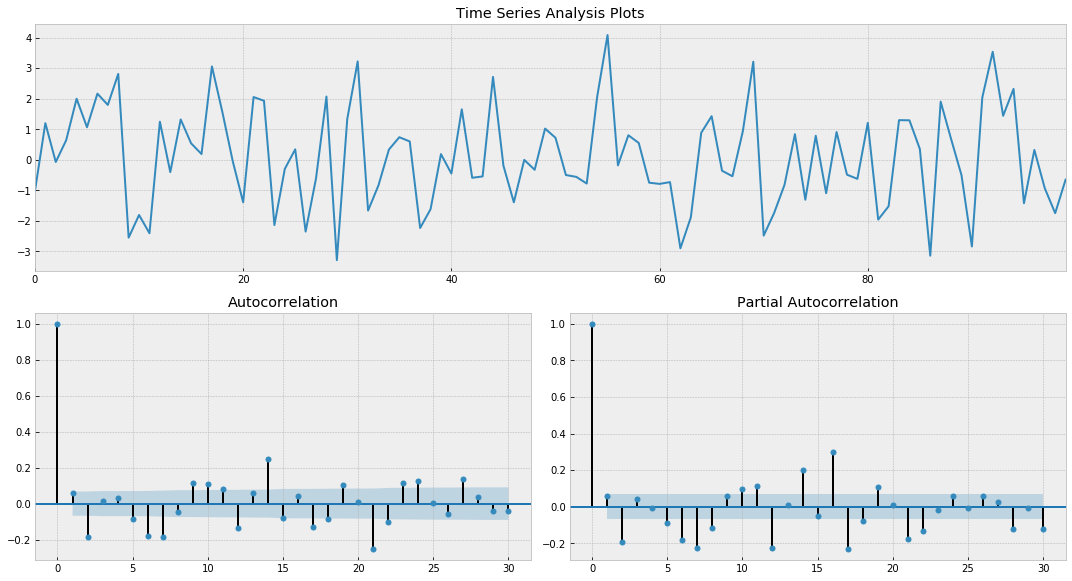

In [37]:
#arch model 

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=100)
Y = np.empty_like(y)

for t in range(len(y)):
    y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(y, lags=30)

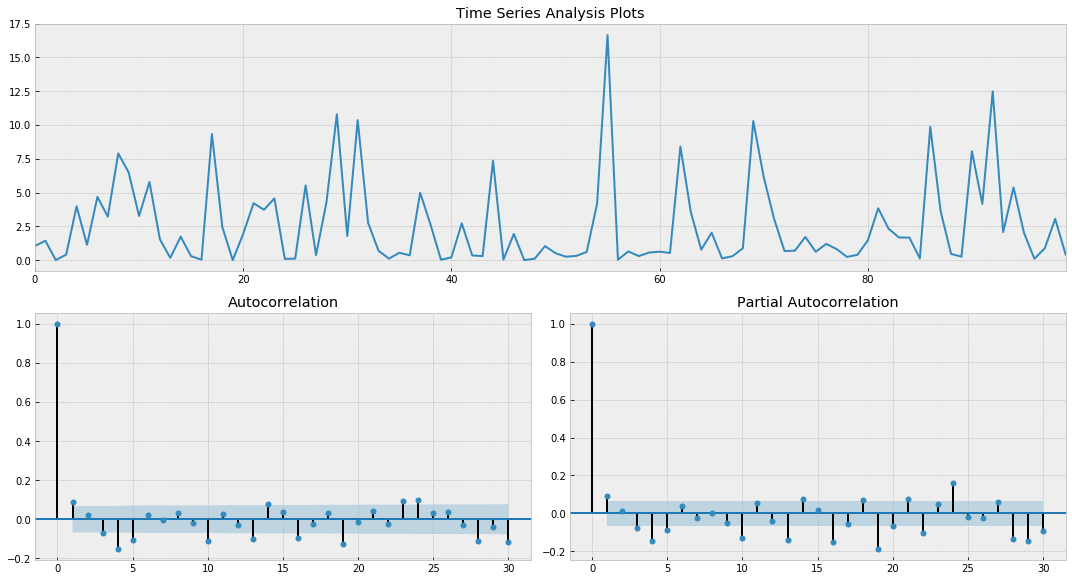

In [38]:
tsplot(y**2, lags=30)

In [ ]:
The AR(p) models the variance of the residuals (squared errors) or simply our time series squared.
The MA(q) portion models the variance of the process.
garch = ar + ma (arma)

The GARCH(1,1) model is:

σ²(t) = a*σ²(t-1) + b*e²(t-1) + w

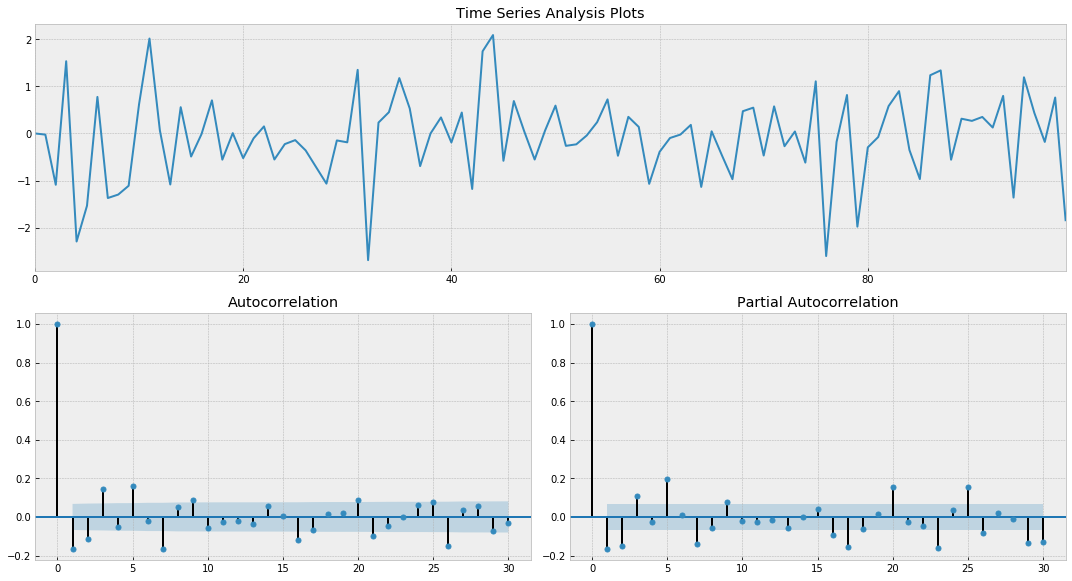

In [39]:

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 100
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

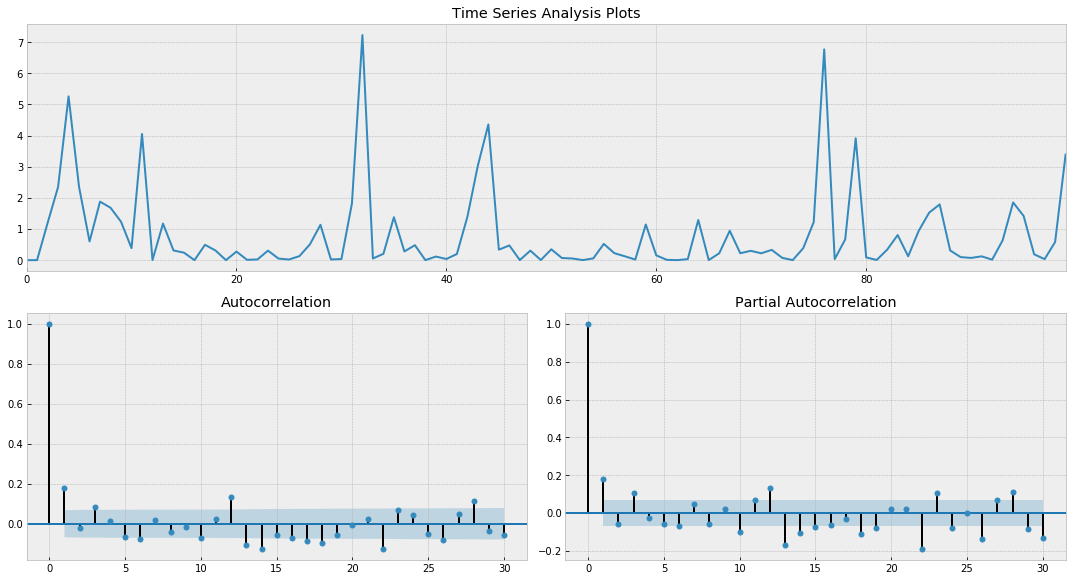

In [40]:
tsplot(eps**2, lags=30)

In [58]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 123.75121952385064
Iteration:     10,   Func. Count:     67,   Neg. LLF: 122.46770578929281
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 122.46757173741912
            Iterations: 12
            Function evaluations: 79
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -122.468
Distribution:                  Normal   AIC:                           252.935
Method:            Maximum Likelihood   BIC:                           263.356
                                        No. Observations:                  100
Date:                Mon, Mar 04 2019   Df Residuals:                       96
Time:      

In [62]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.SPY.loc['2012-01-01':'2015-01-01']
TS.head(3)
res_tup = _get_best_model(TS)


/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated

/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated

/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aryann/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated

aic: -5255.56617 | order: (3, 0, 2)


In [56]:
order= (3, 0, 2)
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                2244.17
Distribution:      Standardized Student's t   AIC:                          -4472.33
Method:                  Maximum Likelihood   BIC:                          -4435.33
                                              No. Observations:                  754
Date:                      Mon, Mar 04 2019   Df Residuals:                      746
Time:                              09:38:51   Df Model:                            8
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

/home/aryann/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
